## Physics Informed Neural Networks for Inverse Problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

Consider the one-dimensional heat equation:

$$
u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$

with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

The equation parameter $k:[0,T]\times[-1,1]\mapsto \mathbb{R} $ denotes the medium conductivity and $s:[0,T]\times[-1,1]\mapsto \mathbb{R}$ is a source term.

We want to solve a parameter identification inverse problem, which can be formulated as follows:

Given observation measurements of the medium temperature

$$
S_{meas}=\{(t_i, x_i, u^{meas}_{i})\}_{i=1}^{N_{meas}},
$$
find $u: [0,T]\times[-1,1]\mapsto\mathbb{R}$ and $k:[-1,1]\mapsto \mathbb{R}$, such that

$$u_t(t, x) = k(t,x)u_{xx}(t, x) + s(t,x),
\\ u_b(t, -1)=u_b(t,1)=0 \quad\text{   and  } \quad u(x, 0) = u_0(x) = -\sin(\pi x).$$






\\


To do so, we approximate the underlying solution and the medium conductivity with two feedforward dense neural network with tunable parameters $\theta$ and $\phi$:

$$
u_\theta(t,x) \approx u(t,x), \quad k_\phi(t, x) \approx k(t, x)
$$

In [2]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


We define the following residuals:

   - Interior residual given by,
   $$r_{int,\theta, \phi}(t, x):=  u_{\theta, t}(t, x) - k_\phi(t,x)u_{\theta, xx}(t, x) -s(t,x), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   

        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta, \phi) = \int_{[0,T]\times[-1,1]}r_{int,\theta, \phi}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad 1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences:

$$
L_{int}(\theta, \phi) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta,\phi}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

Also the measurements data $S_{meas}$ have to taken into account. To do so, we define ad additional loss term:
$$
L_{meas} = \frac{1}{N_{meas}}\sum_{i=1}^{N_{mean}}(u_\theta(t_i, x_i) - u^{meas}_i)^2(x_n)
$$
and eventually solve the following minimization problem

$$
\theta^\ast, \phi^\ast = argmin_{\theta, \phi} \Big(L_{int}(\theta, \phi) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta) + L_{meas}(\theta)
$$

\\

\\

\\

In the following let us assume

$$u_{ex}(t,x) = -\exp(-\pi^2 t)\sin(\pi x), \quad k(t,x)=k(x)=\sin(\pi x).$$

Then, the source term $s$ can be computed by plugging the expression above in the PDE:

$$
s(t,x) = -\pi^2u_{ex}(t,x)*(1 - k(t,x))
$$

Moreover, let us assume that the measurments data are given as follows:

$$
u_{meas}(x_i, t_i) = u_{ex}(x_i t_i) + 0.01\xi, \quad \xi \sim \mathcal{N(0, 1)}
$$

where $\mathcal{N(0, 1)}$ is a standard normal distribution.



In [3]:
# Initial condition to solve the heat equation u0(x)=-sin(pi x)
def initial_condition(x):
    return -torch.sin(np.pi * x)

# Exact solution for the heat equation ut = u_xx with the IC above
def exact_solution(inputs):
    t = inputs[:, 0]
    x = inputs[:, 1]

    u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
    return u

def exact_conductivity(inputs):
    t = inputs[:, 0]
    x = inputs[:, 1]
    k = (torch.sin(np.pi * x) + 1.1)

    return k


def source(inputs):
    s = -np.pi**2*exact_solution(inputs)*(1 - exact_conductivity(inputs))
    return s

In [4]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_


        # Extrema of the solution domain (t,x) in [0,0.1] x [-1,1]
        self.domain_extrema = torch.tensor([[0, 0.1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              retrain_seed=42)

        # FF Dense NN to approximate the conductivity we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0],
                                                 output_dimension=1,
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

        # number of sensors to record temperature
        self.n_sensor = 50

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int


    def get_measurement_data(self):
        torch.random.manual_seed(42)
        # take measurments every 0.001 sec on a set of randomly placed (in space) sensors
        t = torch.linspace(0, self.domain_extrema[0, 1], 25)
        x = torch.linspace(self.domain_extrema[1, 0], self.domain_extrema[1, 1], self.n_sensor)

        #x = torch.rand(self.n_sensor)
        #x = x * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) +  self.domain_extrema[1, 0]

        input_meas = torch.cartesian_prod(t, x)

        output_meas = exact_solution(input_meas).reshape(-1,1)
        noise = 0.01*torch.randn_like(output_meas)
        output_meas = output_meas + noise

        return input_meas, output_meas


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb


    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int).reshape(-1,)
        k = self.approximate_coefficient(input_int).reshape(-1,)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]


        s = source(input_int)


        residual = grad_u_t - k*grad_u_xx - s

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        inp_train_meas, u_train_meas = self.get_measurement_data()
        u_pred_meas = self.approximate_solution(inp_train_meas)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb
        r_meas = u_train_meas - u_pred_meas

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss



Define *fit* function that takes model, num_epoch and optimizer as an input.

It runs the gradient descent and returns history of the loss computed at each epoch (using closure rule, as below).

In [5]:
def fit(model, num_epochs, optimizer, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(model.training_set_sb, model.training_set_tb, model.training_set_int)):
            def closure():
                optimizer.zero_grad()
                loss = model.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                loss.backward()

                history.append(loss.item())
                return loss

            optimizer.step(closure=closure)

    print('Final Loss: ', history[-1])

    return history

Use the code below to plot the exact and the approximate solutions:

In [6]:
def plotting(model):
      inputs = model.soboleng.draw(100000)
      inputs = model.convert(inputs)

      output = model.approximate_solution(inputs).reshape(-1, )
      exact_output = exact_solution(inputs).reshape(-1, )

      fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
      im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
      axs[0].set_xlabel("x")
      axs[0].set_ylabel("t")
      plt.colorbar(im1, ax=axs[0])
      axs[0].grid(True, which="both", ls=":")
      im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
      axs[1].set_xlabel("x")
      axs[1].set_ylabel("t")
      plt.colorbar(im2, ax=axs[1])
      axs[1].grid(True, which="both", ls=":")
      axs[0].set_title("Exact Solution")
      axs[1].set_title("Approximate Solution")

      err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
      print("L2 Relative Error Norm U: ", err.item(), "%")

      approx_cond = model.approximate_coefficient(inputs).reshape(-1, )
      exact_cond = exact_conductivity(inputs).reshape(-1, )


      fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
      im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_cond.detach(), cmap="jet")
      axs[0].set_xlabel("x")
      axs[0].set_ylabel("t")
      plt.colorbar(im1, ax=axs[0])
      axs[0].grid(True, which="both", ls=":")
      im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=approx_cond.detach(), cmap="jet")
      axs[1].set_xlabel("x")
      axs[1].set_ylabel("t")
      plt.colorbar(im2, ax=axs[1])
      axs[1].grid(True, which="both", ls=":")
      axs[0].set_title("Exact Conductivity")
      axs[1].set_title("Approximate Conductivity")

      err = (torch.mean((approx_cond - exact_cond) ** 2) / torch.mean(exact_cond ** 2)) ** 0.5 * 100
      print("L2 Relative Error Norm K: ", err.item(), "%")

      plt.show()

Let us test the code:




In [7]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 128
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

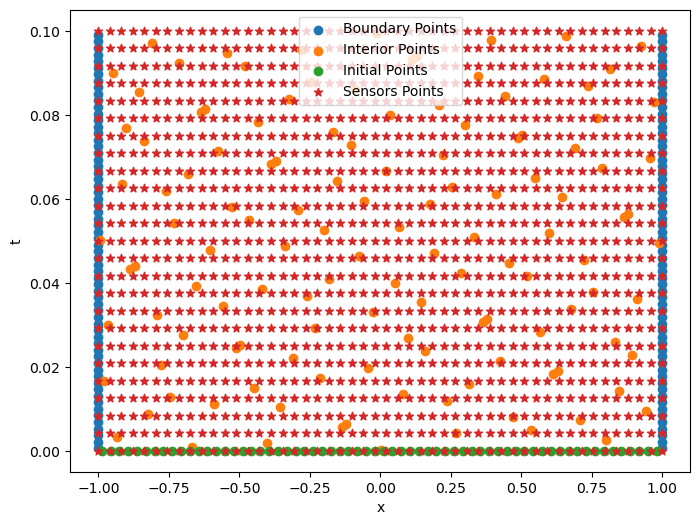

In [8]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [9]:
n_epochs = 1
max_iter = 1000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.5),
                              max_iter=max_iter,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.005))

################################  0  ################################
Total loss:  1.9531 | PDE Loss:  1.8765 | Function Loss:  0.1619
Total loss:  1.9065 | PDE Loss:  1.8389 | Function Loss:  0.0651
Total loss:  1.5213 | PDE Loss:  1.364 | Function Loss:  0.0038
Total loss:  1.6616 | PDE Loss:  0.7443 | Function Loss:  0.6056
Total loss:  1.4444 | PDE Loss:  1.0582 | Function Loss:  0.2146
Total loss:  1.3288 | PDE Loss:  0.9062 | Function Loss:  0.1227
Total loss:  1.0778 | PDE Loss:  0.7612 | Function Loss:  -0.2083
Total loss:  0.9581 | PDE Loss:  0.6291 | Function Loss:  -0.3167
Total loss:  0.9075 | PDE Loss:  0.5671 | Function Loss:  -0.3575
Total loss:  0.8711 | PDE Loss:  0.5103 | Function Loss:  -0.3775
Total loss:  0.8561 | PDE Loss:  0.4919 | Function Loss:  -0.3898
Total loss:  0.8428 | PDE Loss:  0.4761 | Function Loss:  -0.4011
Total loss:  0.8071 | PDE Loss:  0.4409 | Function Loss:  -0.4372
Total loss:  0.7225 | PDE Loss:  0.4093 | Function Loss:  -0.5667
Total loss:  

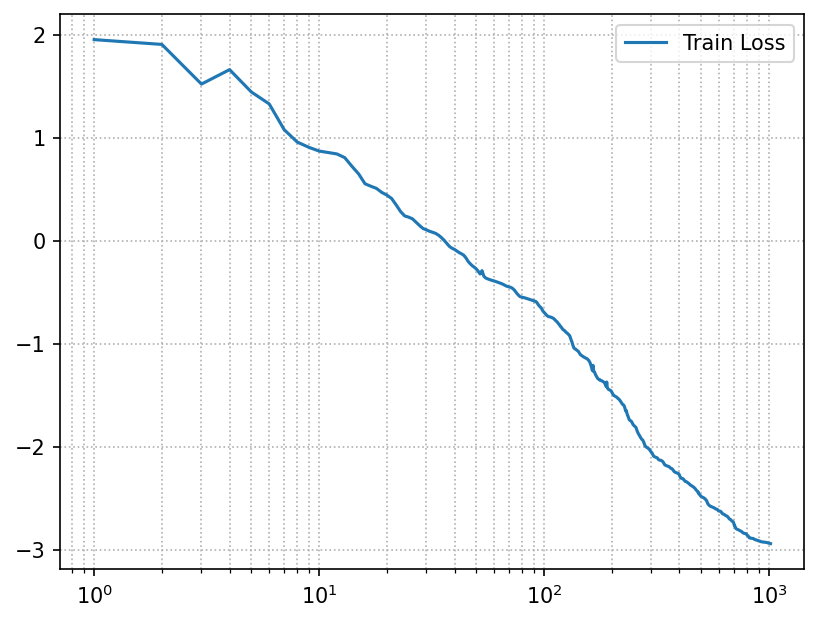

In [10]:
hist = fit(pinn,
          num_epochs=n_epochs,
          optimizer=optimizer_LBFGS,
          verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

L2 Relative Error Norm U:  0.5162886381149292 %
L2 Relative Error Norm K:  5.742745876312256 %


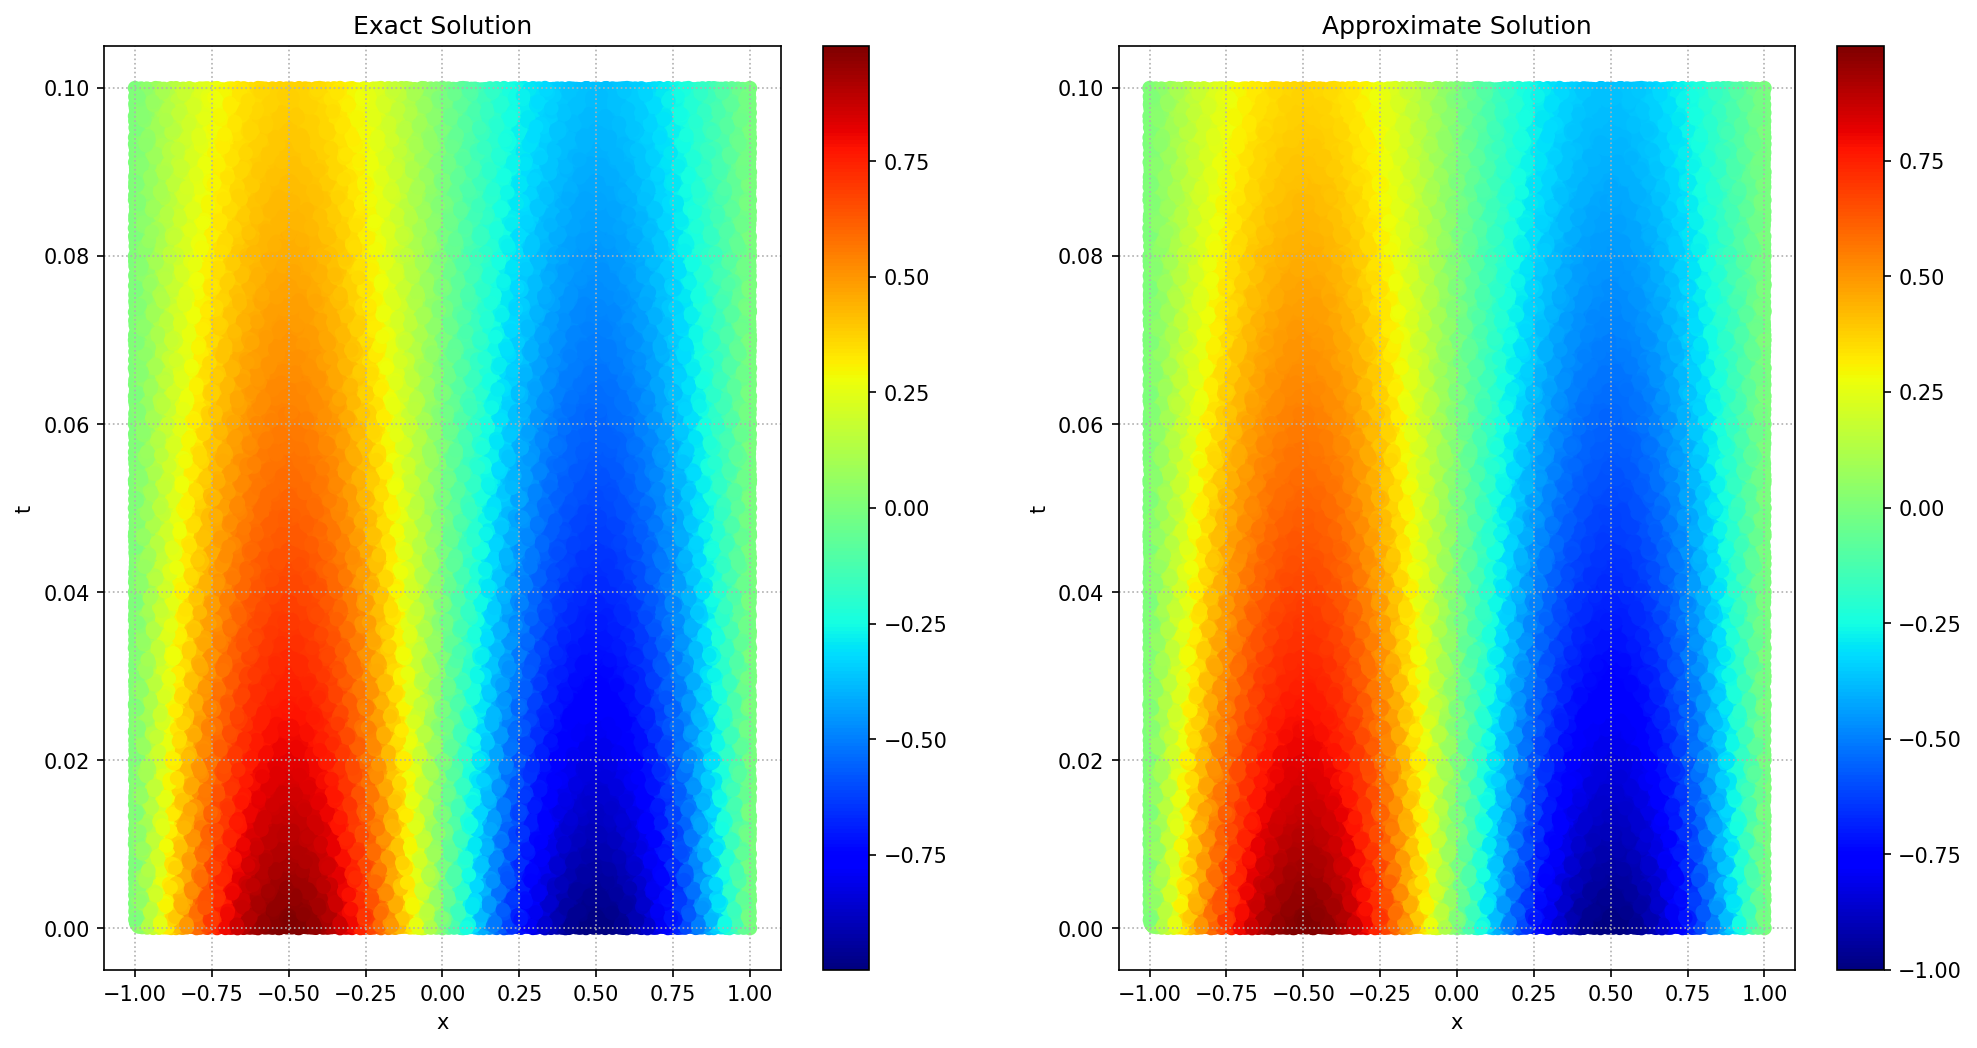

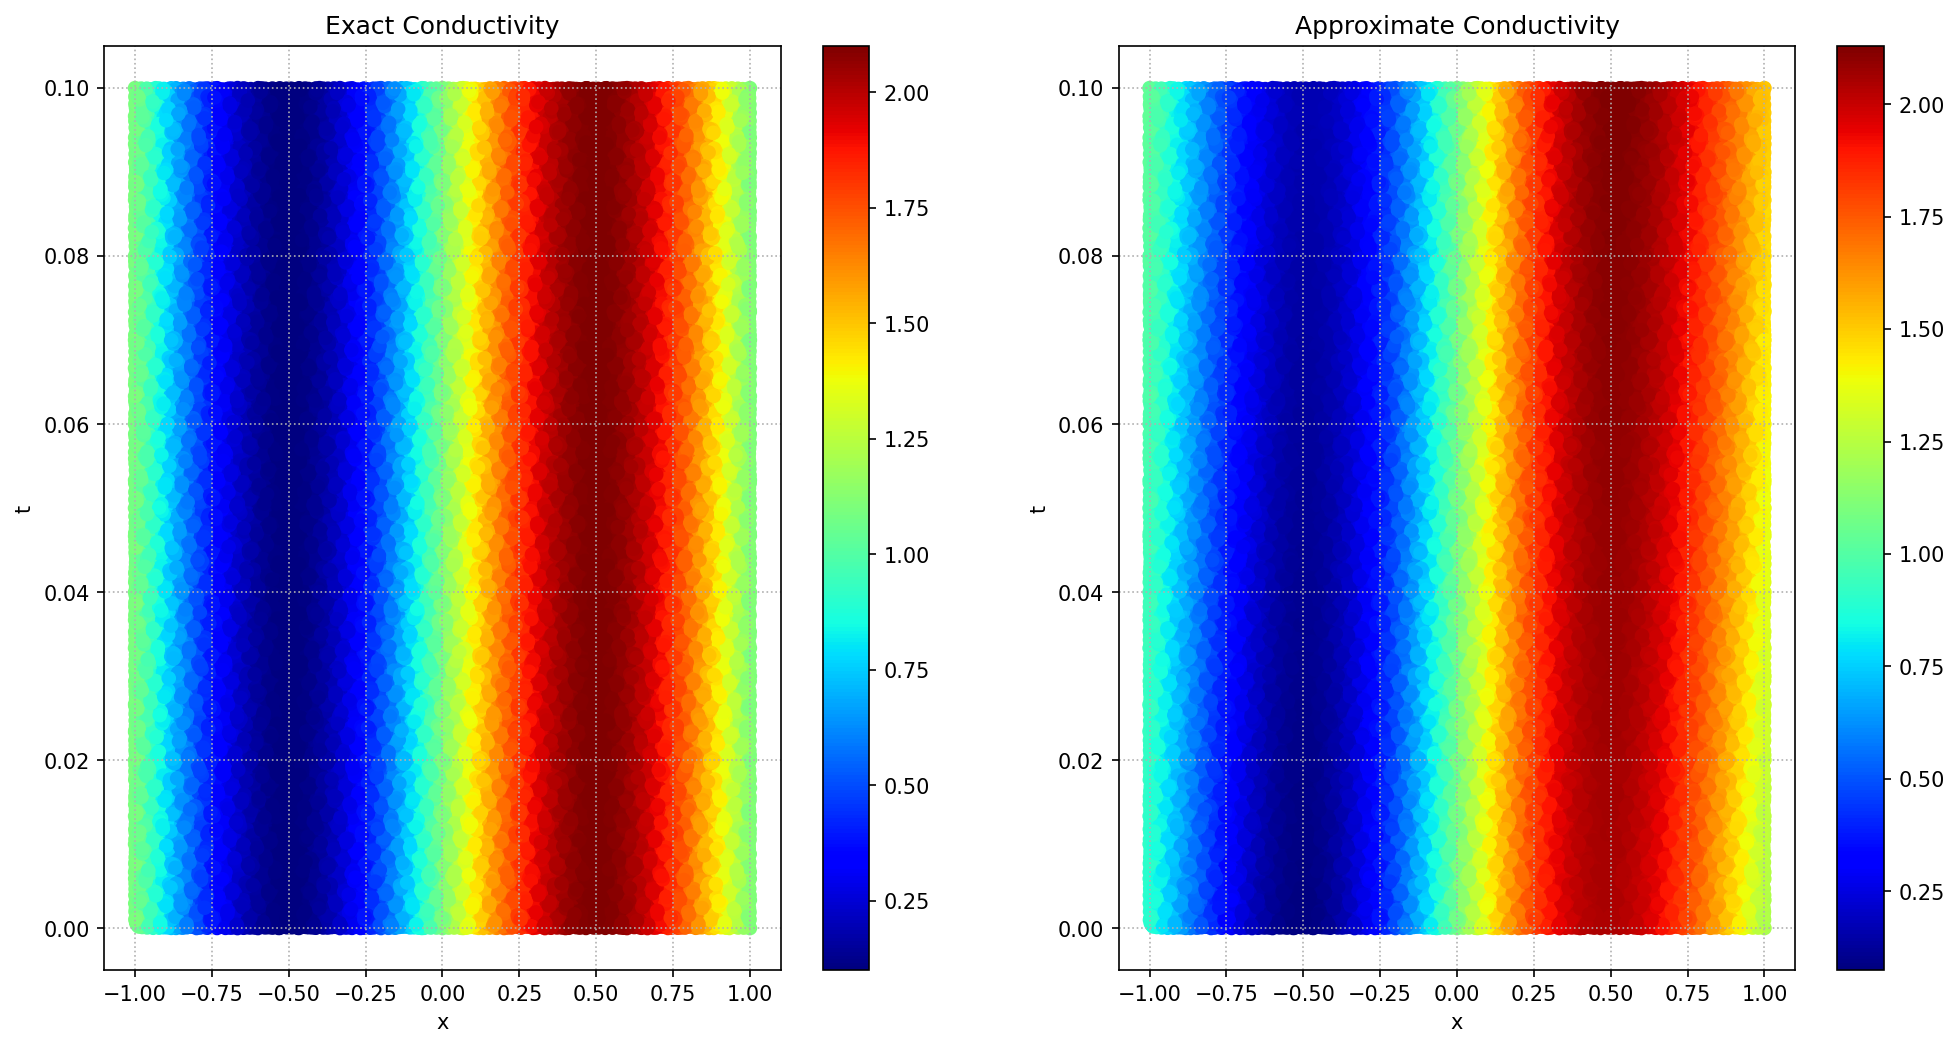

In [11]:
plotting(pinn)